['Ex-smoker' 'Non-smoker' 'Current' 'unknown']


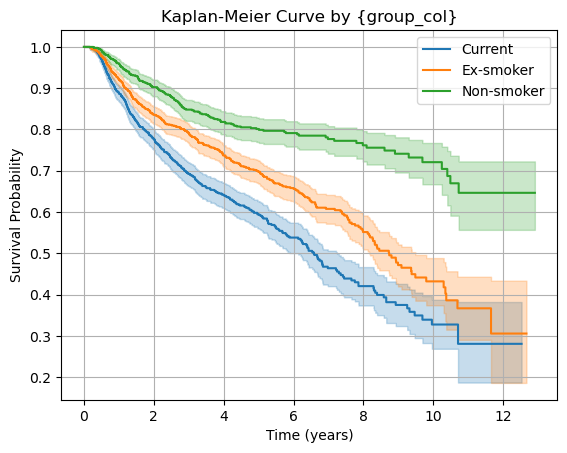

In [10]:
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Read in data
clinical = pd.read_excel('../Data/RADCURE_Clinical_v04_20241219.xlsx')

# Convert status to binary
clinical['Event'] = clinical['Status'].map({'Dead': 1, 'Alive': 0})

print(clinical['Smoking Status'].unique())

# Fit Kaplan-Meier Estimator 
def plot_km(clinical, group_col, group1_name, group2_name, group3_name):
    kmf = KaplanMeierFitter()
    
    # Group 1
    group1 = clinical[clinical[group_col] == group1_name]
    kmf.fit(group1['Length FU'], event_observed=group1['Event'], label=group1_name)
    kmf.plot_survival_function()
    
    # Group 2
    group2 = clinical[clinical[group_col] == group2_name]
    kmf.fit(group2['Length FU'], event_observed=group2['Event'], label=group2_name)
    kmf.plot_survival_function()
    
    #Group 3
    group3 = clinical[clinical[group_col] == group3_name]
    kmf.fit(group3['Length FU'], event_observed=group3['Event'], label=group3_name)
    kmf.plot_survival_function()
    
    # Plot config
    plt.title('Kaplan-Meier Curve by {group_col}')
    plt.xlabel('Time (years)')
    plt.ylabel('Survival Probability')
    plt.grid(True)
    plt.show()

plot_km(clinical, 'Smoking Status', 'Current', 'Ex-smoker', 'Non-smoker')
